Sample measurements and analysis for the QREF material.


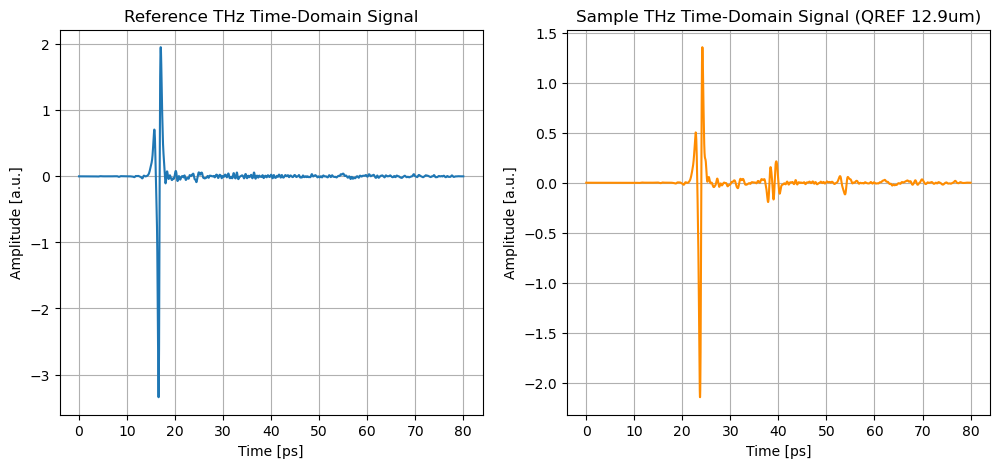

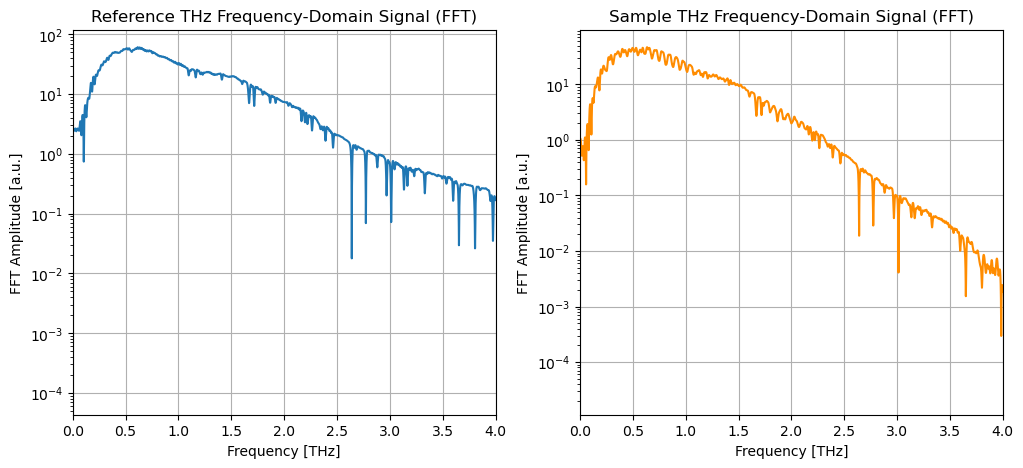

In [51]:
import sys 
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


from Matrix_methods.utils import get_frequency_domain
from Matrix_methods.Simulate import simulate_parallel, simulate_reference
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor



# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_03_02_2026\reference_10min_nitrogen_3.txt",dtype=float)

# INSERT SAMPLE DATA
sample_pulse_QREF = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_03_02_2026\QREF_12.9um_nitrogen_10min.txt",dtype=float)

t1= reference_pulse[:,0] + 740  # ADJUISTING THE AXIS
amp1 = reference_pulse[:,1]
t2 = sample_pulse_QREF[:,0] + 740  # ADJUISTING THE AXIS
amp2 = sample_pulse_QREF[:,1]

# ATTEMPT TO CREATE A TUKEY WINDOW
window_1 = signal.windows.tukey(len(amp1), alpha=0.1)  
window_2 = signal.windows.tukey(len(amp2), alpha=0.1)
amp1 = amp1 * window_1
amp2 = amp2 * window_2

# FFT OF SIGNALS
reference_fft = np.fft.fft(amp1,65536)
sample_fft = np.fft.fft(amp2,65536)

time_step = t1[1] - t1[0]
frequency = np.fft.fftfreq(65536, d=time_step*1e-12)  # Convert ps to s for frequency calculation

# MASK
mask = (frequency > 0) & (frequency < 6.0 * 10**12)
reference_fft = reference_fft[mask]
sample_fft = sample_fft[mask]
frequency = frequency[mask]

# PLOTTING REFERENCE AND SAMPLE SIGNALS


# PLOTS
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1,amp1)
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Reference THz Time-Domain Signal')
plt.grid()  
plt.subplot(1,2,2)
plt.plot(t2,amp2, color='darkorange')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Sample THz Time-Domain Signal (QREF 12.9um)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(frequency*1e-12,np.abs(reference_fft))
plt.xlim(0,4)
plt.yscale('log')
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Reference THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.subplot(1,2,2)
plt.plot(frequency*1e-12,np.abs(sample_fft), color='darkorange')
plt.xlim(0,4)
plt.yscale('log')
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Sample THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.show()


In [52]:
def compare_material_stacks(calculated, real):
    """
    Compare two material parameter stacks with separate real/imag errors for n.
    
    Args:
        calculated (list of tuples): [(n_complex, thickness_m), ...]
        real (list of tuples): [(n_complex, thickness_m), ...]
    
    Returns:
        list of dicts with abs and % errors for n_real, n_imag, and thickness.
    """
    results = []
    for i, ((n_calc, d_calc), (n_true, d_true)) in enumerate(zip(calculated, real), start=1):
        
        # Refractive index real part errors
        n_real_abs_err = abs(n_calc.real - n_true.real)
        n_real_pct_err = (n_real_abs_err / abs(n_true.real)) * 100 if n_true.real != 0 else float('inf')
        
        # Refractive index imaginary part errors
        n_imag_abs_err = abs(n_calc.imag - n_true.imag)
        n_imag_pct_err = (n_imag_abs_err / abs(n_true.imag)) * 100 if n_true.imag != 0 else float('inf')

        # Thickness errors
        d_abs_err = abs(d_calc - d_true)
        d_pct_err = (d_abs_err / abs(d_true)) * 100 if d_true != 0 else float('inf')

        results.append({
            "layer": i,
            "n_real_abs_err": n_real_abs_err,
            "n_real_pct_err": n_real_pct_err,
            "n_imag_abs_err": n_imag_abs_err,
            "n_imag_pct_err": n_imag_pct_err,
            "d_abs_err": d_abs_err,
            "d_pct_err": d_pct_err
        })
    
    return results

In [53]:
# CONVERT DATA TO TENSORS

# REFERENCE PULSE
reference_pulse_tensor = torch.tensor(amp1, dtype=torch.float32)
#SAMPLE PULSE
sample_pulse_tensor = torch.tensor(amp2, dtype=torch.float32)

Delta t:  3.30033000000185e-14
Number of time points, L:  2425
Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.71, 2.11)
Layer 1 - k ∈ (0.0, 0.002)
Layer 1 - D ∈ (0.001097, 0.001103)
Layer 2 - D ∈ (8.6e-06, 1.46e-05)
Layer 3 - n ∈ (1.7, 2.1)
Layer 3 - k ∈ (0.0, 0.002)
Layer 3 - D ∈ (0.001067, 0.001073)
[((1.9632764889335461+0j), 0.001097), ((1+0j), 1.46e-05), ((2.006956542691594+0j), 0.001073)]


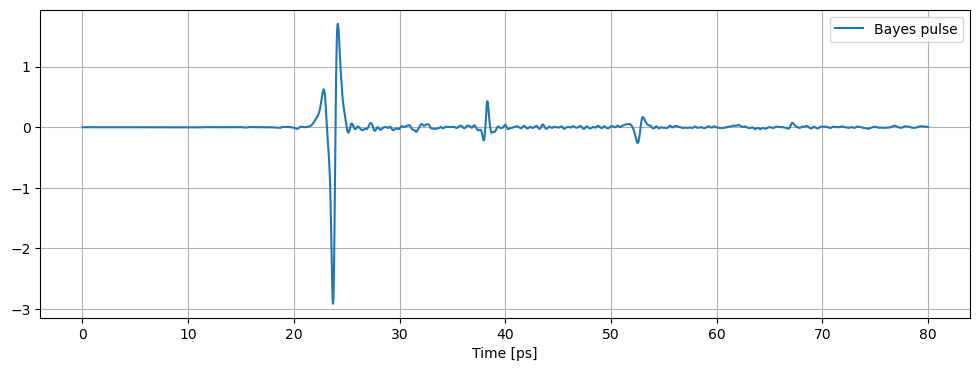

Fine-tuning 7 parameters for 500 iterations.
Iteration 99, Loss: 3.013930e-02, Layer 0: n=1.9628, k=-0.00705, D=1095.68 µm | Layer 1: n=1.0000, k=0.00000, D=14.72 µm | Layer 2: n=2.0067, k=-0.00704, D=1072.03 µm
Iteration 199, Loss: 2.992782e-02, Layer 0: n=1.9635, k=-0.00765, D=1095.12 µm | Layer 1: n=1.0000, k=0.00000, D=14.77 µm | Layer 2: n=2.0073, k=-0.00760, D=1071.27 µm
Iteration 299, Loss: 2.991837e-02, Layer 0: n=1.9641, k=-0.00767, D=1094.62 µm | Layer 1: n=1.0000, k=0.00000, D=14.82 µm | Layer 2: n=2.0079, k=-0.00758, D=1070.51 µm
Iteration 399, Loss: 2.991277e-02, Layer 0: n=1.9646, k=-0.00770, D=1094.25 µm | Layer 1: n=1.0000, k=0.00000, D=14.87 µm | Layer 2: n=2.0083, k=-0.00755, D=1069.93 µm
Iteration 499, Loss: 2.990945e-02, Layer 0: n=1.9648, k=-0.00772, D=1094.03 µm | Layer 1: n=1.0000, k=0.00000, D=14.93 µm | Layer 2: n=2.0086, k=-0.00753, D=1069.52 µm
[((1.9648418426513672-0.007718959823250771j), 0.0010940288193523884), ((1+0j), 1.4931283658370376e-05), ((2.00858879

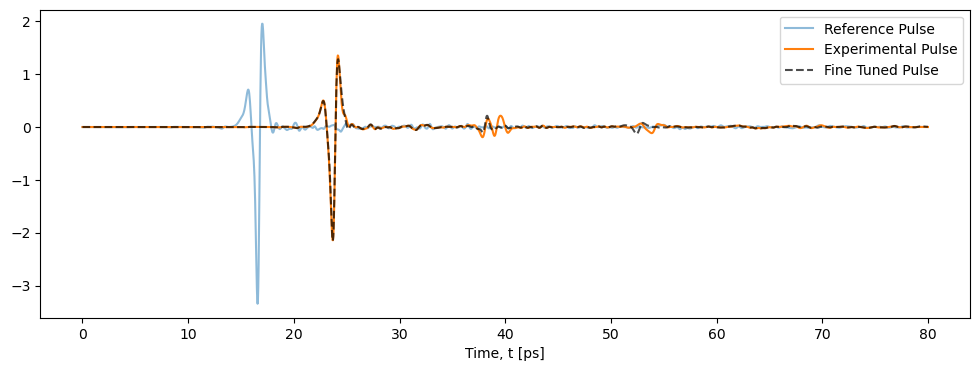

In [ ]:
## Experimental params:

"""
| Refractive Index | Absorption Coeff | Thickness [m] |
|------------------|------------------|----------------| 
|            2.000 |        -0.007331 |      100e-05 | # QUARTZ
|            1.000 |        -0.0015   |      12.9e-06| # AIR
|            2.000 |        -0.007331 |      100e-05 | # QUARTZ
"""
deltat = t1[1] - t1[0]
deltat = deltat * 1e-12
L = len(reference_pulse)


print("Delta t: ", deltat)
print("Number of time points, L: ", L)

optimization_bounds = [0.2, 0.001, 3e-6]

n_inits = [1.91, 1.00, 1.900]
k_inits = [0.001, 0, 0.001]
d_inits = [110e-05, 11.6e-6, 107e-05] 
# d real: [100e-05, 12.9e-6, 100e-5]

layers_init = [[(n_inits[i] + 1j * k_inits[i]), d_inits[i]] for i in range(len(n_inits))]

# Optimize with fixed thickness
optimization_mask = [
    (True, True, True),
    (False, False, True),
    (True, True, True)]


# Initialize extractor for the data
Bayes_extractor = BayesianLayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, layers_init, optimization_bounds=optimization_bounds,optimize_mask=optimization_mask)

# Run the extraction loop and returns parameters
bayes_params = ms = Bayes_extractor.bayesian_optimization(n_calls=60)




# Run forward pass with Jeff’s model
bayes_pulse = simulate_parallel(reference_pulse_tensor,bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

 # Print the parameters
print(bayes_params)

 # plot the pulse
plt.figure(figsize=(12,4))
plt.plot(t1, bayes_pulse, label='Bayes pulse', linestyle='-')
plt.xlabel('Time [ps]')
plt.grid(True)
plt.legend()
plt.show()






 # Initialize adam optimizer object
grad_optimizer = LayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, bayes_params,optimization_mask, lr=0.0001)
# Run optimization for set iterations, ‘updates’ provides a printout of progress
optim_params = grad_optimizer.optimize(num_iterations=500,updates=100)
optim_pulse = simulate_parallel(reference_pulse_tensor,
optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]
print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='Reference Pulse',alpha=0.5)
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),
label='Experimental Pulse')
plt.plot(t1, optim_pulse, label='Fine Tuned Pulse',alpha=0.7, linestyle='--', color='black')
plt.xlabel('Time, t [ps]')
plt.legend() 
plt.show()

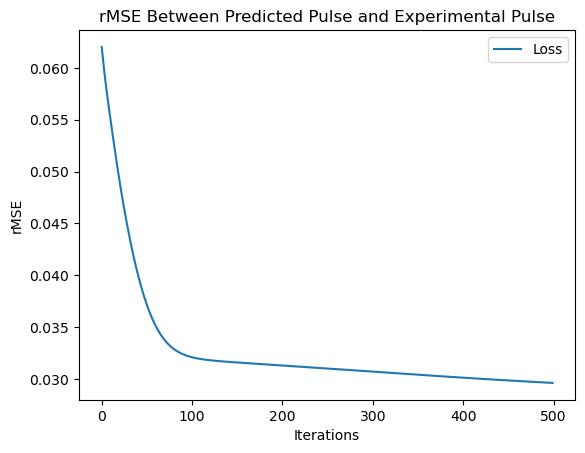

In [55]:
plt.plot(grad_optimizer.loss_history, label='Loss')
plt.xlabel("Iterations")
plt.ylabel("rMSE")
plt.title("rMSE Between Predicted Pulse and Experimental Pulse")
plt.legend()
plt.show()

In [56]:
optim_params 

[((1.8460841178894043-0.009084664285182953j), 0.001065364689566195),
 ((1+0j), 1.6542626326554455e-05),
 ((2.125044345855713-0.005740477237850428j), 0.0010952490847557783)]

In [57]:
# Print initial guesses and optimized parameters
print('Initial guesses we provide during Bayes:')
for i, (n_d, d) in enumerate(layers_init):
    print(f"Layer {i+1}: n = {n_d.real:.4f} + {n_d.imag:.4f}j, d = {d*1e6:.7f} um")

print('\nFinal, optimized parameters [after Adam]:')
for i, (n_d, d) in enumerate(optim_params):
    print(f"Layer {i+1}: n = {n_d.real:.4f} + {n_d.imag:.4f}j, d = {d*1e6:.7f} um")

Initial guesses we provide during Bayes:
Layer 1: n = 2.1000 + 0.0010j, d = 1100.0000000 um
Layer 2: n = 1.0000 + 0.0000j, d = 13.6000000 um
Layer 3: n = 1.9500 + 0.0010j, d = 1100.0000000 um

Final, optimized parameters [after Adam]:
Layer 1: n = 1.8461 + -0.0091j, d = 1065.3646896 um
Layer 2: n = 1.0000 + 0.0000j, d = 16.5426263 um
Layer 3: n = 2.1250 + -0.0057j, d = 1095.2490848 um
